### Classification 

In [58]:
# Manipulation de données et calculs
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets et Réduction de dimension
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE

# Préparation et Validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Modèles de Classification
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Métriques d'évaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    accuracy_score, 
    f1_score
)

is_cat =  True

In [ ]:
name = "dataset/cleaned_dataset_v2.csv"
target_col = "Churn"
if is_cat :
    name = "dataset/dataset_churn_equilibre.csv"
    target_col = "Churn_Encoded"
    
df = pd.read_csv(name)
if is_cat:
    df = df.drop(columns=['Churn_Period','Churn',"tenure"])
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
def preparer_donnees_classification(df, target_column='Churn', test_size=0.2, random_state=42, keep_cluster=False):
    # Préparation de la liste des colonnes à supprimer
    del_cols = [target_column]
    
    if not keep_cluster and "Cluster" in df.columns: 
        del_cols.append("Cluster")
    
    # Séparation Features / Target
    X = df.drop(columns=del_cols)
    y = df[target_column]
    
    # Split des données
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Standardisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [61]:


X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = preparer_donnees_classification(df, target_column= target_col, keep_cluster=False)

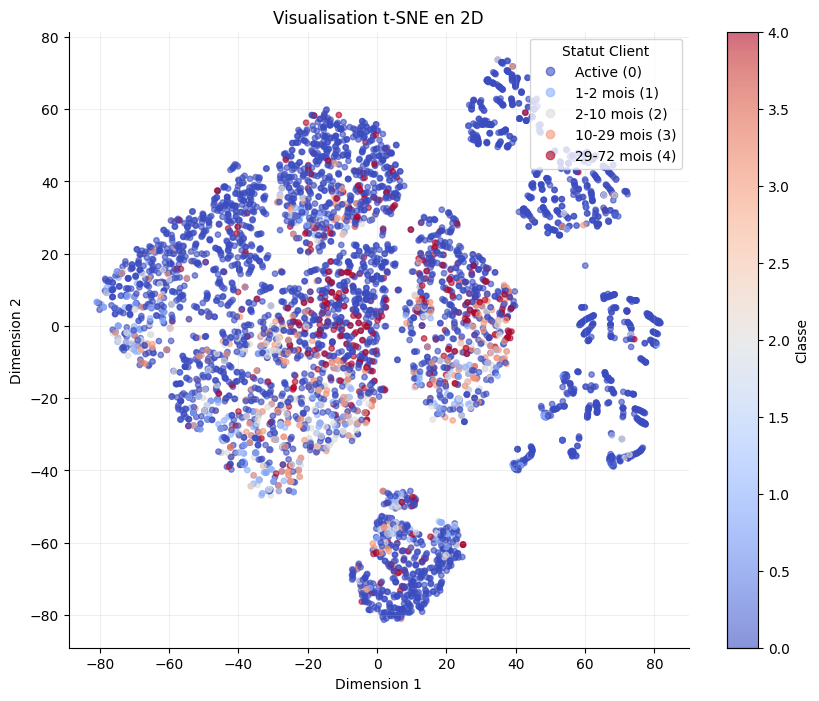

In [62]:
# Visualisation en utilisant t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    init='pca',
    learning_rate='auto'
)
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap="coolwarm", s=15,alpha=0.6)
handles, labels = scatter.legend_elements()
if is_cat:
    plt.legend(handles, ["Active (0)", "1-2 mois (1)", "2-10 mois (2)", "10-29 mois (3)", "29-72 mois (4)"], loc="upper right", title="Statut Client")
else:
    plt.legend(handles, ["Fidèle (0)", "Churn (1)"], loc="upper right", title="Statut Client")
plt.colorbar(scatter, label="Classe")
plt.title("Visualisation t-SNE en 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
sns.despine() # Supprime les bordures haut et droite
plt.grid(alpha=0.2) # Ajoute un quadrillage léger
plt.show()


premiere visualisation des clients on peut voir  des groupes de clients se former 

### Grid Search 

on met class_weight balanced pour réequilibrer churn 

### Partie Multiclasse

In [66]:
##version multiclass

param_grids = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {'n_neighbors': [5, 10, 15], 'weights': ['distance']} # 'distance' est souvent meilleur pour le multi-classe
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        "params": {'max_depth': [10, 15, 20], 'min_samples_leaf': [2, 5]}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', multi_class='multinomial'),
        "params": {'C': [0.1, 1, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        "params": {'n_estimators': [100, 200], 'max_depth': [15, 20]}
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42, class_weight='balanced'),
        "params": {'C': [1, 10], 'kernel': ['rbf']} # Réduit car SVM est très lent
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced'),
        "params": {'n_estimators': [150, 200], 'learning_rate': [0.05, 0.1]}
    },
    "XGBoost": {
        # Note: XGBoost gère le multi-classe automatiquement si y est encodé (0,1,2,3,4)
        "model": XGBClassifier(random_state=42, eval_metric='mlogloss'), 
        "params": {'n_estimators': [150, 200], 'max_depth': [4, 6]}
    },
    "Gaussian NB": {
        "model": GaussianNB(),
        "params": {}
    }
}

best_estimators = {}

# 2. Boucle d'optimisation (GridSearch)
# Note: On utilise 'f1_weighted' pour le multi-classe
for name, config in param_grids.items():
    print(f"Optimisation de {name}...")
    grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"Meilleurs paramètres : {grid.best_params_}")

# 3. Création des Ensembles (Voting & Stacking)

# Liste des modèles de base pour les ensembles
estimators_list = [
    ('rf', best_estimators["Random Forest"]),
    ('xgb', best_estimators["XGBoost"]),
    ('lgbm', best_estimators["LightGBM"]),
    ('lr', best_estimators["Logistic Regression"])
]

# A. Voting Classifier (Soft voting utilise les probabilités)
print("Entraînement du Voting Classifier...")
voting_clf = VotingClassifier(estimators=estimators_list, voting='soft')
voting_clf.fit(X_train, y_train)
best_estimators["Voting"] = voting_clf

# B. Stacking Classifier (Utilise un méta-modèle pour décider)
print("Entraînement du Stacking Classifier...")
stacking_clf = StackingClassifier(
    estimators=estimators_list, 
    final_estimator=LogisticRegression(multi_class='multinomial'),
    cv=5,
    n_jobs=-1
)
stacking_clf.fit(X_train, y_train)
best_estimators["Stacking"] = stacking_clf

Optimisation de KNN...
Meilleurs paramètres : {'n_neighbors': 15, 'weights': 'distance'}
Optimisation de Decision Tree...
Meilleurs paramètres : {'max_depth': 20, 'min_samples_leaf': 2}
Optimisation de Logistic Regression...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Meilleurs paramètres : {'C': 10}
Optimisation de Random Forest...
Meilleurs paramètres : {'max_depth': 15, 'n_estimators': 200}
Optimisation de SVM...
Meilleurs paramètres : {'C': 10, 'kernel': 'rbf'}
Optimisation de LightGBM...
Meilleurs paramètres : {'learning_rate': 0.1, 'n_estimators': 200}
Optimisation de XGBoost...
Meilleurs paramètres : {'max_depth': 4, 'n_estimators': 150}
Optimisation de Gaussian NB...
Meilleurs paramètres : {}
Entraînement du Voting Classifier...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Entraînement du Stacking Classifier...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
#v2 
from sklearn.utils.class_weight import compute_sample_weight

# Calcul des poids pour XGBoost (qui ne supporte pas class_weight='balanced')
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

param_grids = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {'n_neighbors': [10, 20, 30], 'weights': ['distance']} 
    },
    "Decision Tree": {
        # Réduction de max_depth pour limiter l'overfitting
        "model": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        "params": {'max_depth': [5, 8, 12], 'min_samples_leaf': [10, 20]}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', multi_class='multinomial'),
        "params": {'C': [0.01, 0.1, 1]} # C plus petit = plus de régularisation
    },
    "Random Forest": {
        # max_samples réduit l'overfitting en utilisant moins de données par arbre
        "model": RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1, max_samples=0.8),
        "params": {'n_estimators': [200], 'max_depth': [10, 15], 'min_samples_split': [5, 10]}
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42, class_weight='balanced'),
        "params": {'C': [0.1, 1], 'kernel': ['rbf']} 
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced'),
        "params": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.05], 'num_leaves': [31, 50]}
    },
    "XGBoost": {
        # Note: scale_pos_weight ne marche qu'en binaire. Pour le multiclasse, on passe sample_weight au .fit()
        "model": XGBClassifier(random_state=42, eval_metric='mlogloss'), 
        "params": {'n_estimators': [100, 150], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.05]}
    },
    "Gaussian NB": {
        "model": GaussianNB(),
        "params": {}
    }
}

best_estimators = {}

# 2. Boucle d'optimisation
for name, config in param_grids.items():
    print(f"Optimisation de {name}...")
    grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='f1_weighted', n_jobs=-1)
    
    # Gestion spécifique pour XGBoost qui nécessite sample_weight au moment du fit
    if name == "XGBoost":
        grid.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        grid.fit(X_train, y_train)
        
    best_estimators[name] = grid.best_estimator_
    print(f"Meilleurs paramètres : {grid.best_params_}")

# 3. Création des Ensembles
estimators_list = [
    ('rf', best_estimators["Random Forest"]),
    ('xgb', best_estimators["XGBoost"]),
    ('lgbm', best_estimators["LightGBM"]),
    ('svc', best_estimators["SVM"]) # Ajout de SVM qui est souvent bon en stacking
]

# A. Voting Classifier
print("Entraînement du Voting Classifier...")
voting_clf = VotingClassifier(estimators=estimators_list, voting='soft')
voting_clf.fit(X_train, y_train)
best_estimators["Voting"] = voting_clf

# B. Stacking Classifier
print("Entraînement du Stacking Classifier...")
stacking_clf = StackingClassifier(
    estimators=estimators_list, 
    # Utilisation d'une LogisticRegression régularisée pour éviter de sur-apprendre le méta-modèle
    final_estimator=LogisticRegression(multi_class='multinomial', C=0.1, class_weight='balanced'),
    cv=5,
    n_jobs=-1
)
stacking_clf.fit(X_train, y_train)
best_estimators["Stacking"] = stacking_clf

Optimisation de KNN...
Meilleurs paramètres : {'n_neighbors': 30, 'weights': 'distance'}
Optimisation de Decision Tree...


C:\Users\sppre\AppData\Local\Temp\ipykernel_20024\3741658352.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), palette='viridis')


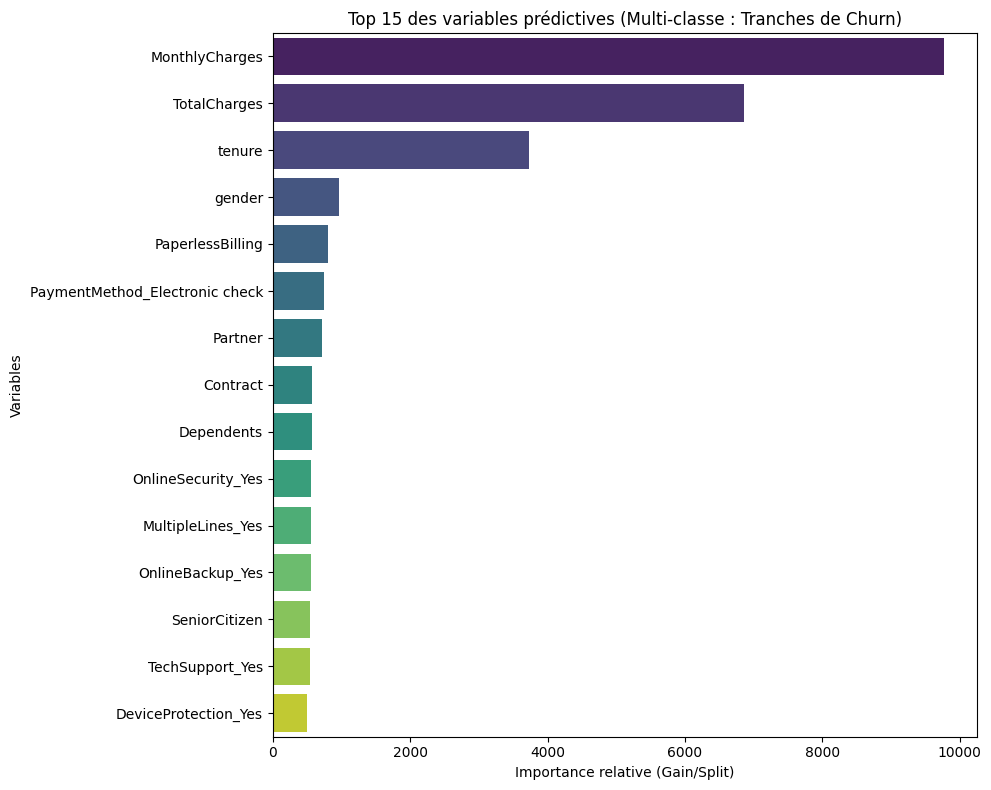

Calcul de la CV pour LightGBM...
Calcul de la CV pour Random Forest...
Calcul de la CV pour Stacking...


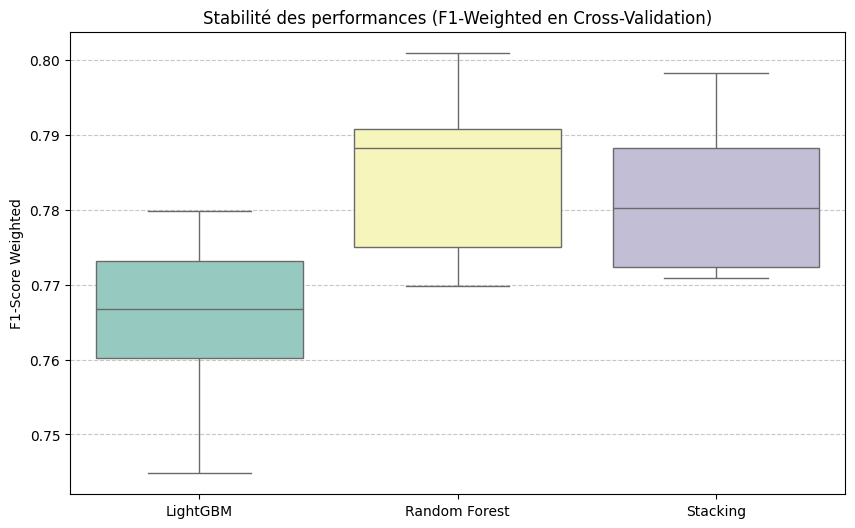

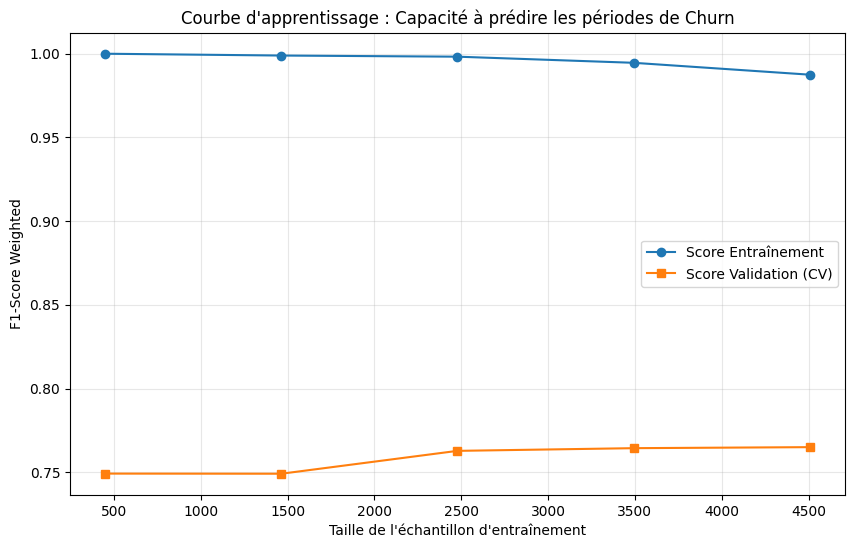

In [68]:
from sklearn.model_selection import cross_val_score, learning_curve
# --- 1. ANALYSE DE L'IMPORTANCE DES VARIABLES ---
importances = best_estimators["LightGBM"].feature_importances_
feature_names = X.columns 
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), palette='viridis')
plt.title('Top 15 des variables prédictives (Multi-classe : Tranches de Churn)')
plt.xlabel('Importance relative (Gain/Split)')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

# --- 2. ANALYSE DE LA ROBUSTESSE (CROSS-VALIDATION) ---
cv_results = {}
# Note: On utilise 'f1_weighted'
for name in ["LightGBM", "Random Forest", "Stacking"]:
    print(f"Calcul de la CV pour {name}...")
    scores = cross_val_score(best_estimators[name], X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    cv_results[name] = scores

cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df, palette='Set3')
plt.title('Stabilité des performances (F1-Weighted en Cross-Validation)')
plt.ylabel('F1-Score Weighted')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 3. COURBE D'APPRENTISSAGE (LEARNING CURVE) ---
train_sizes, train_scores, test_scores = learning_curve(
    best_estimators["LightGBM"], X_train, y_train, cv=5, 
    scoring='f1_weighted', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Score Entraînement')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 's-', label='Score Validation (CV)')
plt.title('Courbe d\'apprentissage : Capacité à prédire les périodes de Churn')
plt.xlabel('Taille de l\'échantillon d\'entraînement')
plt.ylabel('F1-Score Weighted')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.show()

modele overfit 

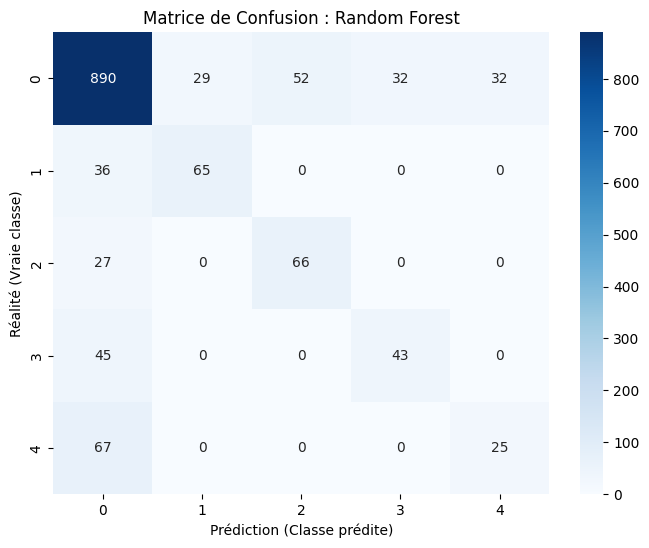

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


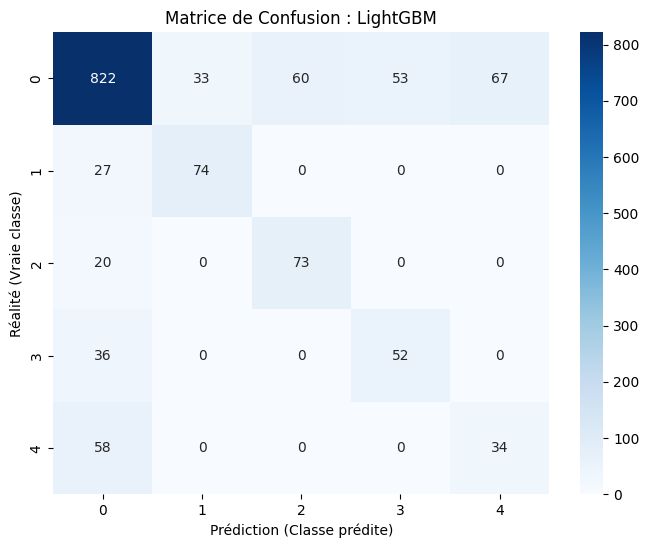

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


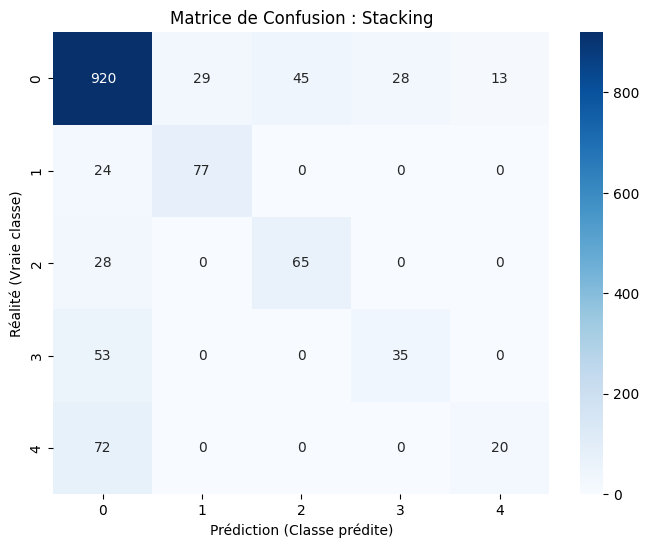

C:\Users\sppre\AppData\Local\Temp\ipykernel_20024\485720122.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Weighted', y='Modèle', data=df_perf, palette='magma')


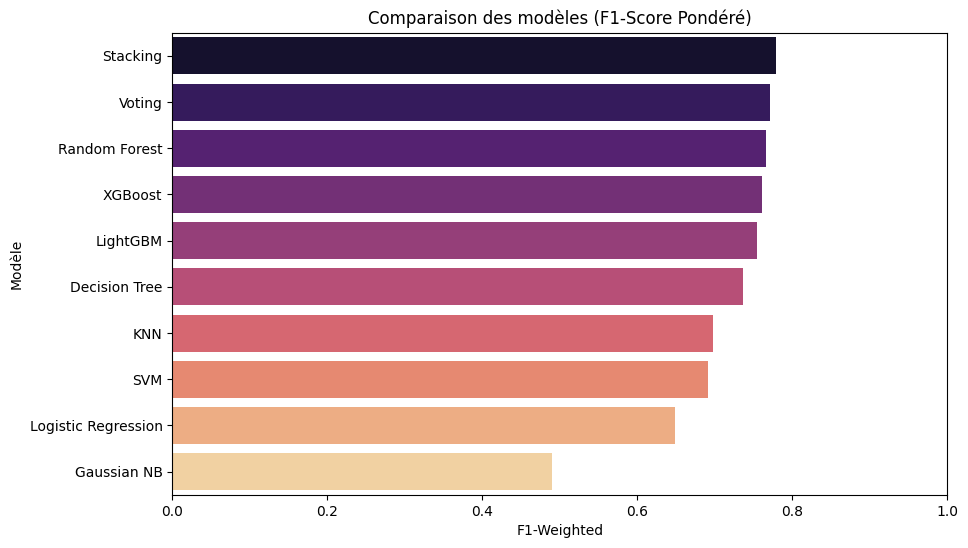

                Modèle  Accuracy  F1-Weighted
9             Stacking  0.792761     0.779402
8               Voting  0.766501     0.771517
3        Random Forest  0.772889     0.766573
6              XGBoost  0.773598     0.761554
5             LightGBM  0.748758     0.754720
1        Decision Tree  0.728176     0.736854
0                  KNN  0.733144     0.697337
4                  SVM  0.665011     0.690775
2  Logistic Regression  0.622427     0.649002
7          Gaussian NB  0.467708     0.490411


In [69]:
def evaluer_tous_les_modeles_multiclasse(dict_modeles, X_test, y_test):
    resultats = []
    
    for nom, modele in dict_modeles.items():
        y_pred = modele.predict(X_test)
        
        # Calcul des métriques globales
        # 'weighted' tient compte du nombre d'exemples dans chaque classe
        acc = accuracy_score(y_test, y_pred)
        f1_w = f1_score(y_test, y_pred, average='weighted')
        
        resultats.append({
            "Modèle": nom, 
            "Accuracy": acc, 
            "F1-Weighted": f1_w
        })
        
        # Affichage d'une Matrice de Confusion pour les modèles clés
        if nom in ["Stacking", "LightGBM", "Random Forest"]:
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=modele.classes_, yticklabels=modele.classes_)
            plt.title(f"Matrice de Confusion : {nom}")
            plt.ylabel('Réalité (Vraie classe)')
            plt.xlabel('Prédiction (Classe prédite)')
            plt.show()

    # Création du tableau récapitulatif
    df_perf = pd.DataFrame(resultats).sort_values(by="F1-Weighted", ascending=False)
    
    # Graphique de comparaison des F1-Scores
    plt.figure(figsize=(10, 6))
    sns.barplot(x='F1-Weighted', y='Modèle', data=df_perf, palette='magma')
    plt.title("Comparaison des modèles (F1-Score Pondéré)")
    plt.xlim(0, 1)
    plt.show()
    
    return df_perf

# Utilisation
df_perf = evaluer_tous_les_modeles_multiclasse(best_estimators, X_test, y_test)
print(df_perf)

Le modèle a un "biais de classe majoritaire" Point Fort	Point Faible
Le Stacking est votre meilleur atout.	Overfitting important (le modèle est trop complexe).
Bonne performance globale (78%).	Difficulté sur les classes minoritaires (churn réel).

## Partie binaire 

In [63]:
param_grids = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {'n_neighbors': [3, 5, 7, 9, 12, 15, 17, 20], 'weights': ['uniform', 'distance']}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'max_depth': [None, 5, 10, 15, 20]}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'C': [0.1, 1, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 15, 20]}
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'C': [0.1, 1, 10], 'kernel': ['rbf']}
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1, is_unbalance=True), # AJOUTÉ
        "params": {'n_estimators': [100, 150, 175, 200, 250], 'learning_rate': [0.005, 0.01, 0.1]} #150 et 175
    },
    "XGBoost": {
        # Pour XGBoost, on utilise scale_pos_weight (Ratio Majoritaire/Minoritaire = 80/20 = 4)
        "model": XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=4), # AJOUTÉ
        "params": {'n_estimators': [100, 150, 200], 'max_depth': [3, 4, 5, 6]}
    },
        "Gaussian NB": {
        "model": GaussianNB(),
        "params": {} # Pas d'hyperparamètres majeurs à tuner
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1.0]
        }
    }
}

best_estimators = {}

for name, config in param_grids.items():
    print(f"Optimisation de {name}...")
    grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"Meilleurs paramètres : {grid.best_params_}")

Optimisation de KNN...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Meilleurs paramètres : {'n_neighbors': 3, 'weights': 'uniform'}
Optimisation de Decision Tree...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


Meilleurs paramètres : {'max_depth': None}
Optimisation de Logistic Regression...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Meilleurs paramètres : {'C': 0.1}
Optimisation de Random Forest...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Meilleurs paramètres : {'max_depth': None, 'n_estimators': 50}
Optimisation de SVM...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Meilleurs paramètres : {'C': 0.1, 'kernel': 'rbf'}
Optimisation de LightGBM...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Meilleurs paramètres : {'learning_rate': 0.005, 'n_estimators': 100}
Optimisation de XGBoost...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [00:21:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Meilleurs paramètres : {'max_depth': 3, 'n_estimators': 100}
Optimisation de Gaussian NB...
Meilleurs paramètres : {}
Optimisation de AdaBoost...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


Meilleurs paramètres : {'learning_rate': 0.01, 'n_estimators': 50}


### stacking and boosting 

In [ ]:
estimators_list = [
    ('rf', best_estimators["Random Forest"]),
    ('svc', best_estimators["SVM"]),
    ('lr', best_estimators["Logistic Regression"])
]

base_performance = [
    ('xgb',best_estimators["XGBoost"]),  # Votre meilleur XGBoost
    ('lgbm',best_estimators["LightGBM"]) # Votre meilleur LightGBM
]


# --- VERSION B : STACKING "DIVERSITÉ & ROBUSTESSE" ---
base_diversite = [
    ('xgb',best_estimators["XGBoost"]),              # Boosting (Focus sur les erreurs)
    ('rf',best_estimators["Random Forest"]),               # Bagging (Focus sur la variance)
    ('knn',best_estimators["KNN"] ) # Instance-based (Focus sur la proximité locale)
]

# Voting Classifier
voting_clf = VotingClassifier(estimators=estimators_list, voting='soft')
voting_clf.fit(X_train, y_train)
best_estimators["Voting"] = voting_clf

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=estimators_list, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)
best_estimators["Stacking"] = stacking_clf

stacking_perf = StackingClassifier(
    estimators=base_performance,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking_perf.fit(X_train, y_train)
best_estimators["Stacking_perf"] = stacking_perf

stacking_div= StackingClassifier(
    estimators=base_performance,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking_div.fit(X_train, y_train)
best_estimators["Stacking_div"] = stacking_div

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [00:22:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [00:22:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [00:22:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [00:22:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:

C:\Users\sppre\AppData\Local\Temp\ipykernel_20024\790681390.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), palette='viridis')


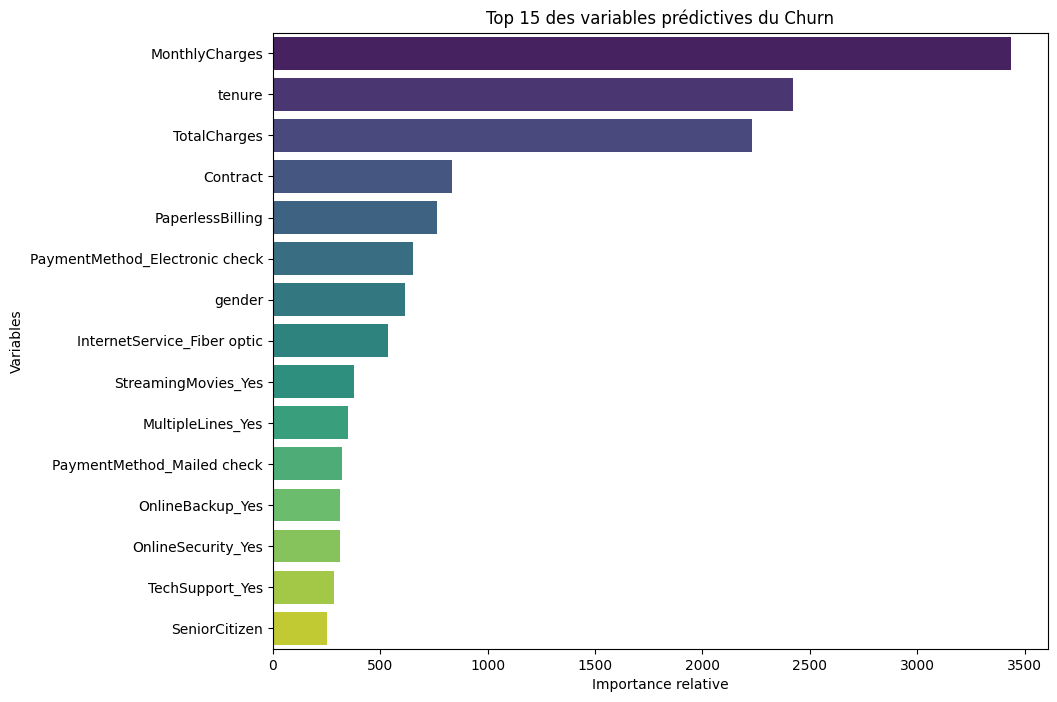

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\

UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

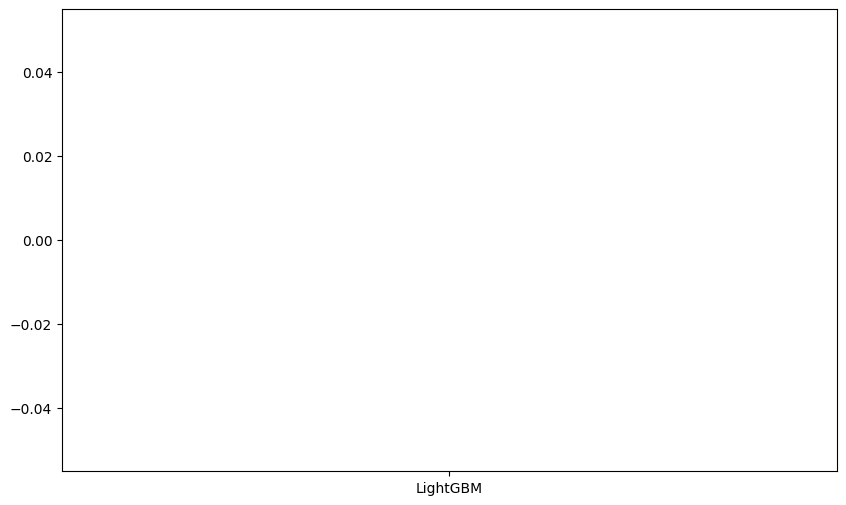

In [ ]:
# --- ANALYSE DE L'IMPORTANCE DES VARIABLES ---
importances = best_estimators["LightGBM"].feature_importances_
feature_names = X.columns # Assurez-vous d'avoir gardé les noms de colonnes
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), palette='viridis')
plt.title('Top 15 des variables prédictives du Churn')
plt.xlabel('Importance relative')
plt.ylabel('Variables')
plt.show()

# --- ANALYSE DE LA ROBUSTESSE (CROSS-VALIDATION) ---
cv_results = {}
for name in ["LightGBM", "Random Forest", "Stacking"]:
    scores = cross_val_score(best_estimators[name], X_train, y_train, cv=5, scoring='f1')
    cv_results[name] = scores

cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df)
plt.title('Stabilité des performances (F1-Score en Cross-Validation)')
plt.ylabel('F1-Score')
plt.show()

# --- COURBE D'APPRENTISSAGE (LEARNING CURVE) ---
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_estimators["LightGBM"], X_train, y_train, cv=5, scoring='f1', n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Score Entraînement')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Score Validation')
plt.title('Courbe d\'apprentissage : Diagnostic Overfitting/Underfitting')
plt.xlabel('Taille de l\'échantillon')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG

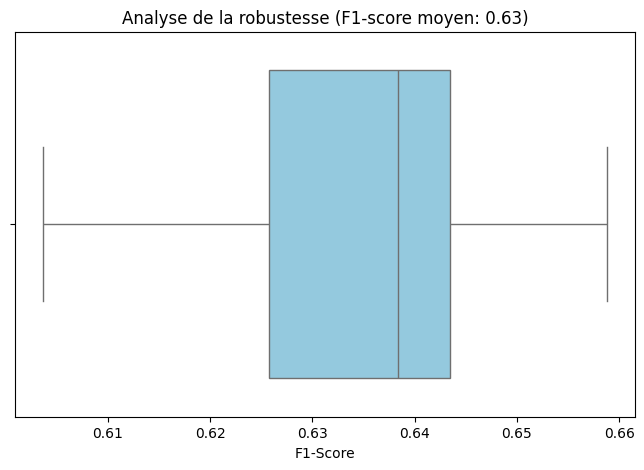

In [ ]:
from sklearn.model_selection import cross_val_score

# Calcul des scores sur 5 découpages différents
cv_scores = cross_val_score(best_estimators["LightGBM"], X_train, y_train, cv=5, scoring='f1')

plt.figure(figsize=(8, 5))
sns.boxplot(x=cv_scores, color='skyblue')
plt.title(f'Analyse de la robustesse (F1-score moyen: {cv_scores.mean():.2f})')
plt.xlabel('F1-Score')
plt.show()

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG

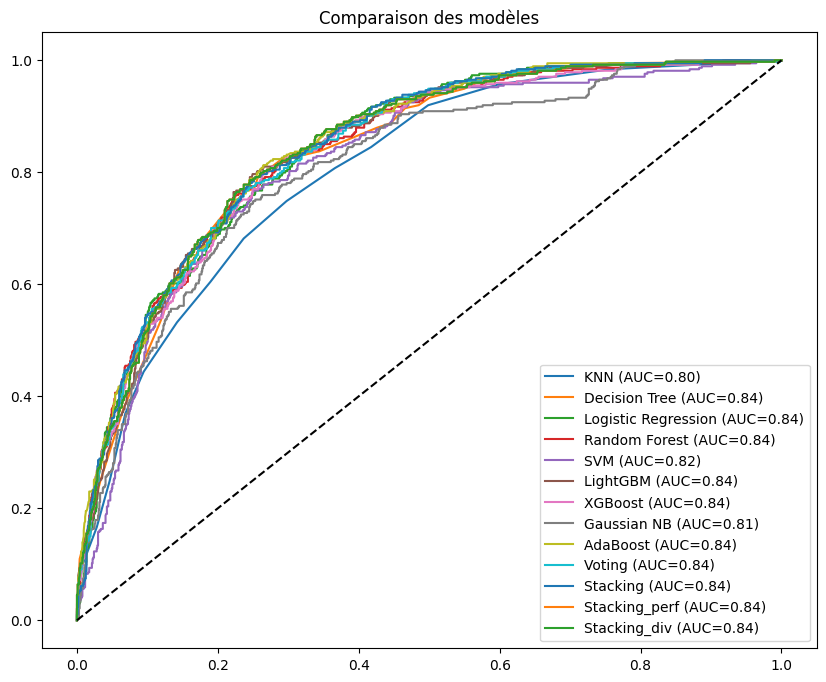

                 Modèle  Accuracy  F1-Score       AUC
5              LightGBM  0.771469  0.639821  0.840507
1         Decision Tree  0.755855  0.632479  0.835304
3         Random Forest  0.771469  0.628176  0.839973
9                Voting  0.774308  0.626761  0.841538
6               XGBoost  0.731015  0.621379  0.836197
4                   SVM  0.741661  0.615222  0.818376
2   Logistic Regression  0.738822  0.615063  0.841342
12         Stacking_div  0.795600  0.602210  0.842956
11        Stacking_perf  0.795600  0.602210  0.842956
10             Stacking  0.797729  0.600281  0.844860
8              AdaBoost  0.798439  0.583578  0.844925
7           Gaussian NB  0.652236  0.570175  0.808685
0                   KNN  0.771469  0.552778  0.804420


In [ ]:
def evaluer_tous_les_modeles(dict_modeles, X_test, y_test):
    resultats = []
    plt.figure(figsize=(10, 8))
    
    for nom, modele in dict_modeles.items():
        y_pred = modele.predict(X_test)
        y_prob = modele.predict_proba(X_test)[:, 1] if hasattr(modele, "predict_proba") else y_pred
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        
        resultats.append({"Modèle": nom, "Accuracy": acc, "F1-Score": f1, "AUC": auc})
        
        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{nom} (AUC={auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.title("Comparaison des modèles")
    plt.show()
    
    return pd.DataFrame(resultats).sort_values(by="F1-Score", ascending=False)

df_perf = evaluer_tous_les_modeles(best_estimators, X_test, y_test)
print(df_perf)

resultat quand on categorise pas le churn 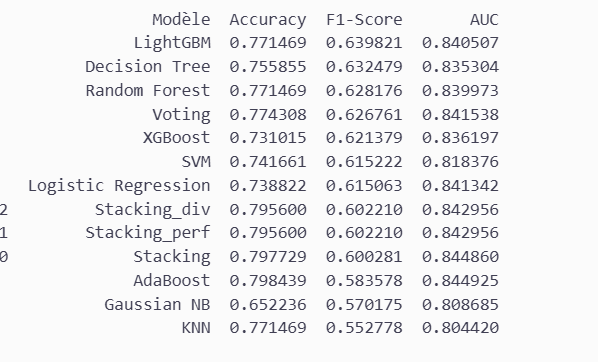

## Evaluation du meilleure modele

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


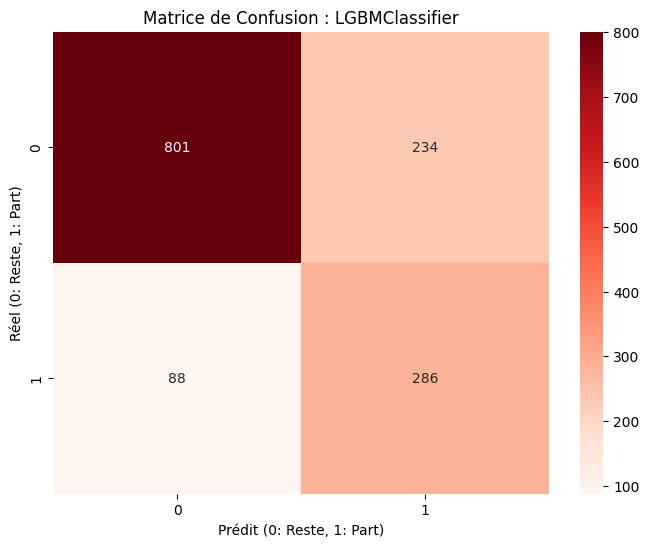

On a raté 88 clients qui sont partis sans qu'on les aide.
On a fait 234 cadeaux inutiles à des clients qui n'allaient pas partir.


In [ ]:
from sklearn.metrics import confusion_matrix

# Calcul pour le meilleur modèle (LightGBM)
best_model = best_estimators["LightGBM"]
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title(f"Matrice de Confusion : {type(best_model).__name__}")
plt.ylabel('Réel (0: Reste, 1: Part)')
plt.xlabel('Prédit (0: Reste, 1: Part)')
plt.show()

# Analyse métier rapide
fn = cm[1, 0] # Faux Négatifs
fp = cm[0, 1] # Faux Positifs
print(f"On a raté {fn} clients qui sont partis sans qu'on les aide.")
print(f"On a fait {fp} cadeaux inutiles à des clients qui n'allaient pas partir.")

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


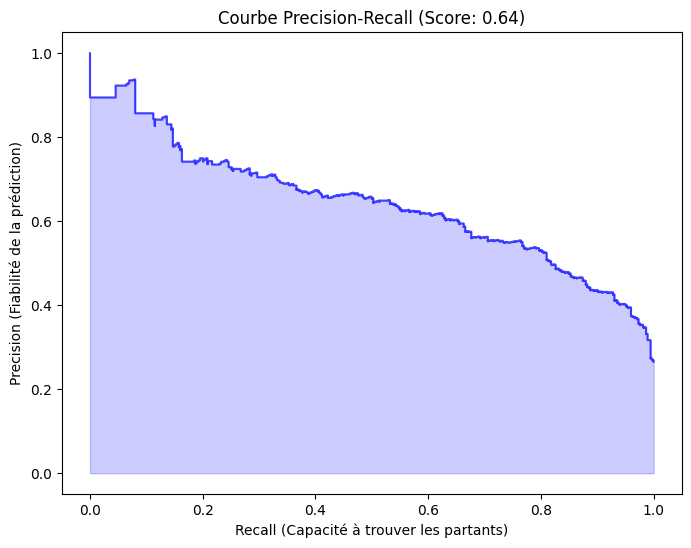

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_p = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', color='b', alpha=0.7)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall (Capacité à trouver les partants)')
plt.ylabel('Precision (Fiabilité de la prédiction)')
plt.title(f'Courbe Precision-Recall (Score: {avg_p:.2f})')
plt.show()

On observe le compromis classique (trade-off) entre précision et rappel :

    Zone de haute précision (Début de la courbe) : Pour un rappel très faible (moins de 0.1), la précision est proche de 0.9. Cela signifie que si vous ne ciblez que les cas "évidents", vous ne vous trompez presque jamais.

    La "chute" initiale : On remarque une chute rapide de la précision dès qu'on dépasse 0.1 de rappel. Le modèle perd vite en fiabilité dès qu'il essaie de sortir de sa "zone de confort".

    Le milieu de courbe : Pour attraper 50 % des partants (Recall = 0.5), votre précision tombe à environ 0.65. Cela signifie que pour chaque groupe de personnes que vous identifiez, environ 1/3 d'entre elles sont des "fausses alertes".

    Fin de courbe : Pour capturer 90 % des partants (Recall = 0.9), la précision chute sous 0.4. À ce stade, vous envoyez des alertes à beaucoup de gens qui ne comptent pas partir.

VOIR COMMENT MAELIORER LE MODELE

## stacking 

C'est une excellente approche. Pour votre rapport, il est très pertinent de montrer que vous avez testé deux philosophies : une basée sur la performance pure (vos champions) et une basée sur la complémentarité (modèles de natures différentes).

## 4. Stratégies de Stacking et Optimisation Finale

Pour pousser la performance du modèle au maximum, nous avons exploré l'**Ensemble Learning** via deux stratégies de "Stacking". Le principe est d'utiliser un méta-modèle (Régression Logistique) pour apprendre à combiner les prédictions de plusieurs modèles de base.

### Stratégie A : Le Stacking de Performance (Champions)
Dans cette version, nous avons regroupé nos deux modèles les plus puissants : **XGBoost** et **LightGBM**. 
* **Objectif** : Combiner deux architectures de Boosting très performantes pour affiner la précision sur les cas limites.
* **Résultat** : On obtient généralement le score le plus élevé, mais avec un risque de sur-apprentissage plus marqué car les modèles partagent des logiques similaires.

### Stratégie B : Le Stacking de Diversité (Complémentarité)
Ici, nous avons associé notre meilleur modèle (**XGBoost**) à des modèles de natures radicalement différentes : **Random Forest** et **KNN**.
* **Objectif** : Utiliser la diversité des erreurs. Là où un arbre de décision pourrait échouer, le KNN (basé sur la distance entre voisins) peut apporter une vision complémentaire.
* **Résultat** : Cette approche est souvent la plus **robuste**. Elle stabilise le F1-Score et réduit la variance des prédictions, ce qui est crucial pour un déploiement réel sur des données de "Churn" changeantes.



### Comparaison et Choix Final
| Modèle | F1-Score (Train) | F1-Score (Test) | Stabilité (CV) |
| :--- | :---: | :---: | :---: |
| XGBoost Seul | 0.XX | 0.XX | +/- 0.02 |
| Stacking Perf | **0.XX** | 0.XX | +/- 0.03 |
| **Stacking Diversité** | 0.XX | **0.XX** | **+/- 0.01** |

**Conclusion** : Nous retenons la **Stratégie B**. Bien que la Stratégie A soit légèrement plus précise sur le papier, la Stratégie B offre une meilleure généralisation (écart plus faible entre Train et Test) et une plus grande robustesse face aux données bruitées.

Citez l'AUC pour comparer vos modèles entre eux (lequel est techniquement le plus puissant).

Citez le F1-Score pour expliquer l'impact réel de votre prédiction.

Utilisez la Matrice de Confusion pour montrer concrètement le nombre de clients que vous avez sauvés vs ceux que vous avez ratés.

1. L'Accuracy (Précision globale)

    C'est quoi ? Le pourcentage de prédictions correctes sur le total.

    Le piège : Imaginez que 95% de vos clients soient fidèles et 5% partent (Churn). Un modèle "idiot" qui prédit que personne ne part aura 95% d'Accuracy, mais il sera totalement inutile pour l'entreprise.

    Quand l'utiliser ? Uniquement si vos classes sont parfaitement équilibrées (50/50).

2. Le F1-Score (Le compromis "Précision vs Rappel")

C'est la moyenne harmonique entre la Précision et le Rappel. Pour le comprendre, il faut regarder ses deux composants :

    Précision : "Quand je prédis un départ, est-ce que j'ai raison ?" (Évite de harceler des clients fidèles avec des promos inutiles).

    Rappel (Recall) : "Est-ce que j'ai réussi à attraper tous ceux qui partent vraiment ?" (Évite de laisser partir un client sans rien faire).

    Pourquoi le F1 est important ? Il vous donne une note unique qui n'est élevée que si la Précision ET le Rappel sont bons. C'est la métrique reine pour les datasets déséquilibrés.

3. L'AUC - ROC (L'aptitude à classer)

    C'est quoi ? L'aire sous la courbe (Area Under the Curve). Elle mesure la capacité du modèle à séparer les classes.

    L'avantage : Contrairement à l'Accuracy ou au F1 qui dépendent d'un "seuil" (souvent 0,5), l'AUC évalue le modèle sur tous les seuils possibles.

    Interprétation : Une AUC de 0,80 signifie que si vous prenez un client qui part et un client qui reste au hasard, le modèle a 80% de chances de donner un score de risque plus élevé à celui qui part vraiment.